Install Libraries

In [ ]:
pip install torch torchvision ultralytics opencv-python numpy onnx onnxruntime-gpu roboflow opencv-python pillow transformer

  Using cached ultralytics-8.3.221-py3-none-any.whl.metadata (37 kB)
  Using cached onnx-1.19.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.0 kB)
  Using cached onnxruntime_gpu-1.23.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.4 kB)
ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0

In [ ]:
pip install ultralytics

  Using cached ultralytics-8.3.221-py3-none-any.whl.metadata (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00


Import Dataset & GPU

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="8xzI8R9A3ass2VFqDh4K")
project = rf.workspace("research-methodology-ylir4").project("palm-oil-ripeness-n72bo")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Oil-Ripeness-1 in yolov11:: 100%|██████████| 4864/4864 [00:00<00:00, 5514.40it/s]


In [ ]:
import torch, subprocess, os
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
try:
    subprocess.run(["nvidia-smi"], check=False)
except Exception as e:
    print("nvidia-smi not available:", e)


CUDA available: True
GPU: Tesla T4


Model Training

In [ ]:
from ultralytics import RTDETR
from pathlib import Path
import torch

DATA_YAML = "/content/Palm-Oil-Ripeness-1/data.yaml"
WEIGHTS   = "rtdetr-l.pt"
DEVICE    = 0 if torch.cuda.is_available() else "cpu"

model = RTDETR(WEIGHTS)

model.train(
    data=DATA_YAML,
    epochs=100,
    imgsz=640,
    batch=8,
    device=DEVICE,
    name="rtdetr_l_train"
)
metrics = model.val(data=DATA_YAML, imgsz=640, device=DEVICE)
print("mAP50-95:", metrics.results_dict.get("metrics/mAP50-95(B)"))

PRED_SRC = "/content/Palm-Oil-Ripeness-1/test/images"
model.predict(
    source=PRED_SRC,
    imgsz=640,
    conf=0.60,
    iou=0.7, #Intersection over Union: Metric that measures the overlap between a predicted bounding box and a ground-truth bounding box.
    device=DEVICE,
    save=True,
    name="rtdetr_l_predict"
)


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Palm-Oil-Ripeness-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetr_l_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       1/50      6.91G     0.3047      4.065     0.4435         24        640: 100% ━━━━━━━━━━━━ 212/212 1.6it/s 2:16
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 2.3it/s 13.3s
                   all        489        518      0.716      0.192       0.14     0.0963

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      7.43G     0.2432     0.9945     0.3414         24        640: 0% ──────────── 0/212  0.8s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       2/50      7.43G     0.2263     0.7747     0.3351         16        640: 100% ━━━━━━━━━━━━ 212/212 1.6it/s 2:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.3it/s 9.3s
                   all        489        518      0.731      0.697      0.652      0.446

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      7.49G     0.2894     0.6736     0.3922         25        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       3/50      7.49G     0.2169     0.7171     0.3238         18        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518       0.74      0.685      0.586      0.424

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50       7.5G     0.2333     0.8204     0.3745         24        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       4/50       7.5G      0.215     0.6693      0.318         21        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.604      0.648      0.588      0.425

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50       7.5G     0.1824     0.7309     0.3109         22        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       5/50       7.5G     0.2045     0.6645     0.3049         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.724      0.708      0.637      0.459

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      7.49G     0.1836     0.6265     0.2236         25        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       6/50      7.49G     0.2054     0.6436     0.3069         21        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.615      0.601      0.514      0.382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      7.39G     0.2427     0.7861     0.3424         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       7/50       7.4G     0.2034     0.6462     0.3021         27        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.713      0.666        0.6      0.445

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50       7.5G     0.2209     0.5331     0.2684         28        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       8/50       7.5G     0.2033     0.6299     0.2972         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.731      0.706      0.652        0.5

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50       7.5G     0.2176     0.4831     0.3279         20        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


       9/50       7.5G     0.1907     0.6002     0.2876         18        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.795      0.804      0.769      0.578

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50       7.5G     0.1976     0.5621     0.3277         19        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      10/50       7.5G     0.1961     0.6244     0.2891         24        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.714      0.689      0.638      0.482

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50       7.4G     0.2036     0.4985     0.3267         21        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      11/50       7.4G     0.1883      0.594     0.2792         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.746      0.762      0.735      0.545

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      7.49G     0.1774     0.5632      0.262         21        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      12/50      7.49G     0.1975     0.5754      0.288         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.824      0.814      0.797      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      7.49G     0.1871     0.5617     0.2673         25        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      13/50       7.5G     0.1869     0.5728     0.2768         25        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.8s
                   all        489        518      0.791      0.755      0.738      0.548

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      7.49G     0.2357     0.7779     0.3147         25        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      14/50      7.49G     0.1874      0.566     0.2771         19        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.861      0.793       0.79      0.601

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50       7.5G     0.2432     0.6489     0.3011         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      15/50       7.5G     0.1834     0.5595     0.2748         20        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.829      0.837       0.81      0.622

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50      7.39G     0.1384     0.5037     0.2112         27        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      16/50      7.39G     0.1804     0.5428     0.2714         13        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518       0.82      0.815      0.803      0.628

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      7.49G     0.2143     0.5547     0.2831         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      17/50      7.49G     0.1846     0.5309     0.2731         27        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.856      0.836      0.813      0.629

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      7.49G     0.1908     0.5813     0.3057         23        640: 0% ──────────── 0/212  0.8s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      18/50      7.49G     0.1825     0.5127     0.2757         20        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.868       0.87      0.858      0.672

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50       7.5G     0.2191     0.5098     0.2507         24        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      19/50       7.5G     0.1788       0.52     0.2693         22        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.881      0.884      0.873      0.675

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      7.49G     0.1545     0.4224     0.2345         24        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      20/50      7.49G     0.1767     0.5035     0.2639         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.814      0.808       0.79      0.609

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50       7.5G     0.1752     0.5579     0.2442         24        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      21/50       7.5G     0.1724     0.4975     0.2589         18        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.8s
                   all        489        518      0.778      0.784      0.782      0.613

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50       7.5G     0.1682     0.7743     0.3257         19        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      22/50       7.5G     0.1755     0.5016     0.2621         19        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.895      0.897      0.892      0.684

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      7.49G     0.1788     0.3328     0.2677         17        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      23/50      7.49G     0.1747     0.4937     0.2605         24        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.868       0.83      0.816      0.629

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50       7.5G     0.1203     0.4304     0.2211         19        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      24/50       7.5G     0.1709     0.4802      0.258         16        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.891      0.855      0.847      0.664

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50       7.5G     0.1485     0.4423     0.2032         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      25/50       7.5G     0.1693      0.473     0.2567         22        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.851      0.857      0.833      0.664

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      7.42G     0.1596     0.3738     0.2312         17        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      26/50      7.42G     0.1667     0.4453     0.2524         18        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.864       0.86      0.854      0.664

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50       7.5G     0.2166      0.508     0.3443         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      27/50       7.5G     0.1673     0.4618     0.2523         20        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518        0.9      0.888      0.892      0.718

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50       7.5G     0.1349     0.4207     0.2307         26        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      28/50       7.5G     0.1659     0.4575     0.2471         18        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.911      0.878      0.895      0.708

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50       7.4G     0.1761     0.4461     0.2386         26        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      29/50       7.4G     0.1646     0.4329     0.2487         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.893       0.86      0.862      0.662

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      7.49G     0.1438     0.3929     0.2817         19        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      30/50      7.49G     0.1604     0.4133     0.2424         21        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.904      0.893       0.87      0.689

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      7.39G     0.1701     0.4566     0.2667         23        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      31/50       7.4G     0.1618     0.4152     0.2427         17        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.913      0.916      0.918      0.722

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50       7.5G     0.1563     0.3851     0.2257         25        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      32/50       7.5G     0.1563     0.4108     0.2375         22        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.895      0.875      0.859      0.677

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50       7.5G     0.1855     0.6174     0.2364         24        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      33/50       7.5G     0.1595     0.4077     0.2382         24        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.901      0.878      0.892      0.706

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50       7.5G     0.1661     0.6212     0.2298         23        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      34/50       7.5G     0.1635     0.4165     0.2466         21        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.926      0.909      0.916      0.718

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50       7.5G     0.1509     0.4604     0.1851         29        640: 0% ──────────── 0/212  0.8s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      35/50       7.5G     0.1601     0.3931     0.2392         19        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.937      0.907      0.915       0.73

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      7.49G     0.1889     0.5029     0.2711         24        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      36/50      7.49G     0.1567     0.3889     0.2377         20        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.919      0.893        0.9       0.71

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      7.49G     0.1195      0.334     0.1908         28        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      37/50      7.49G      0.154     0.3839     0.2322         29        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518       0.92      0.903      0.907      0.722

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50       7.5G     0.1471     0.3876      0.288         20        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      38/50       7.5G     0.1563     0.3837     0.2329         23        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.911      0.899      0.879      0.689

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50       7.5G     0.1561     0.3489     0.2168         22        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      39/50       7.5G     0.1494     0.3742     0.2256         12        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.878      0.904      0.879      0.701

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      7.39G      0.112     0.2367     0.2163         23        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      40/50      7.39G     0.1478     0.3626     0.2216         20        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.936      0.921      0.922      0.736
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50       7.5G    0.08511     0.2763     0.1953          8        640: 0% ──────────── 0/212  1.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      41/50       7.5G     0.0986     0.2648     0.2106          7        640: 100% ━━━━━━━━━━━━ 212/212 1.6it/s 2:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.905      0.903      0.894      0.709

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50       7.5G    0.07379     0.2325     0.1477          8        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      42/50       7.5G    0.09169      0.242     0.1911          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.944      0.908      0.913      0.736

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50       7.5G    0.08043     0.1636     0.1674          8        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      43/50       7.5G     0.0889     0.2161      0.189          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.926      0.924      0.916      0.738

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50       7.5G     0.1043      0.624      0.186          8        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      44/50       7.5G    0.08803     0.2216     0.1779          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.946      0.911      0.926      0.751

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50       7.5G    0.07544     0.2142     0.2421          8        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      45/50       7.5G    0.08271     0.1914     0.1766          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.926      0.919      0.915      0.738

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      7.49G    0.07797     0.1513     0.1354          8        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      46/50      7.49G    0.08489     0.2002     0.1754          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.939      0.917      0.926      0.747

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      7.49G     0.1496      0.345     0.3257          9        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      47/50      7.49G    0.08619     0.1908     0.1801          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.1s
                   all        489        518      0.957      0.921      0.928      0.753

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50       7.5G    0.08032     0.1565     0.1778          8        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      48/50       7.5G    0.08172     0.1824      0.168          8        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.4it/s 9.0s
                   all        489        518      0.946      0.916      0.923      0.752

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50       7.5G    0.06618     0.4432     0.1783          8        640: 0% ──────────── 0/212  0.6s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      49/50       7.5G    0.08107     0.1758     0.1677          7        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 8.9s
                   all        489        518      0.941      0.937      0.937       0.76

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      7.49G    0.08484     0.1571     0.1585          9        640: 0% ──────────── 0/212  0.7s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)


      50/50      7.49G    0.08033      0.177     0.1669          8        640: 100% ━━━━━━━━━━━━ 212/212 1.7it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.5it/s 9.0s
                   all        489        518      0.936      0.932      0.929      0.755

50 epochs completed in 1.977 hours.
Optimizer stripped from /content/runs/detect/rtdetr_l_train2/weights/last.pt, 66.2MB
Optimizer stripped from /content/runs/detect/rtdetr_l_train2/weights/best.pt, 66.2MB

Validating /content/runs/detect/rtdetr_l_train2/weights/best.pt...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,996,070 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 3.3it/s 9.5s
                   all        489        518      0.941      0.937      0.937       0.76
            

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Empty', 1: 'Overripe', 2: 'Ripe', 3: 'Rotten', 4: 'Underripe', 5: 'Unripe'}
 obb: None
 orig_img: array([[[168, 175, 160],
         [162, 169, 154],
         [151, 158, 143],
         ...,
         [ 53,  57,  81],
         [ 49,  53,  77],
         [ 46,  50,  74]],
 
        [[175, 182, 167],
         [168, 175, 160],
         [155, 162, 147],
         ...,
         [ 53,  57,  81],
         [ 48,  52,  76],
         [ 45,  49,  73]],
 
        [[114, 121, 106],
         [114, 121, 106],
         [ 95, 102,  87],
         ...,
         [ 56,  60,  84],
         [ 51,  55,  79],
         [ 48,  52,  76]],
 
        ...,
 
        [[ 49,  74,  60],
         [ 49,  74,  60],
         [ 49,  74,  60],
         ...,
         [ 87,  94, 113],
         [ 81,  88, 108],
         [ 77,  84, 104]],
 
        [[ 48,  73,  59],
         [ 48,  7

Fine Tuning

In [ ]:
from ultralytics import RTDETR
import torch

model = RTDETR("/content/runs/detect/rtdetr_l_train/weights/best.pt")

model.train(
    data="/content/Palm-Oil-Ripeness-1/data.yaml",
    epochs=30,
    imgsz=960,
    batch=8,
    device=0 if torch.cuda.is_available() else "cpu",
    optimizer="AdamW",
    lr0=2e-4, lrf=0.01,
    cos_lr=True,
    weight_decay=5e-4,
    close_mosaic=10,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.6,  # stronger color/brightness aug
    fliplr=0.5, flipud=0.2,             # more flips
    mixup=0.1, copy_paste=0.1,          # domain blending
    erasing=0.4,
    patience=75,
    name="rtdetr_finetune_field"
)


In [ ]:
from ultralytics import RTDETR
import torch

model = RTDETR("/content/runs/detect/rtdetr_l_train/weights/best.pt")

# You can switch `source` between image, folder, video, or live (0 for webcam)
model.predict(
    source="/content/1.mp4",    # or 0 for live cam, or a folder path
    conf=0.6,                   # tighten confidence
    iou=0.45,                   # suppress overlapping boxes
    imgsz=960,                  # better detail
    device=0 if torch.cuda.is_available() else "cpu",
    stream=False,
    save=True,
    show=True,
    name="rtdetr_tuned_predict"
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# create the parent dir that you're copying into
!mkdir -p /content/drive/MyDrive/rtdetr_runs

# copy everything under /content/runs into a backup folder
!cp -r /content/runs "/content/drive/MyDrive/rtdetr_runs/colab_runs_backup"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


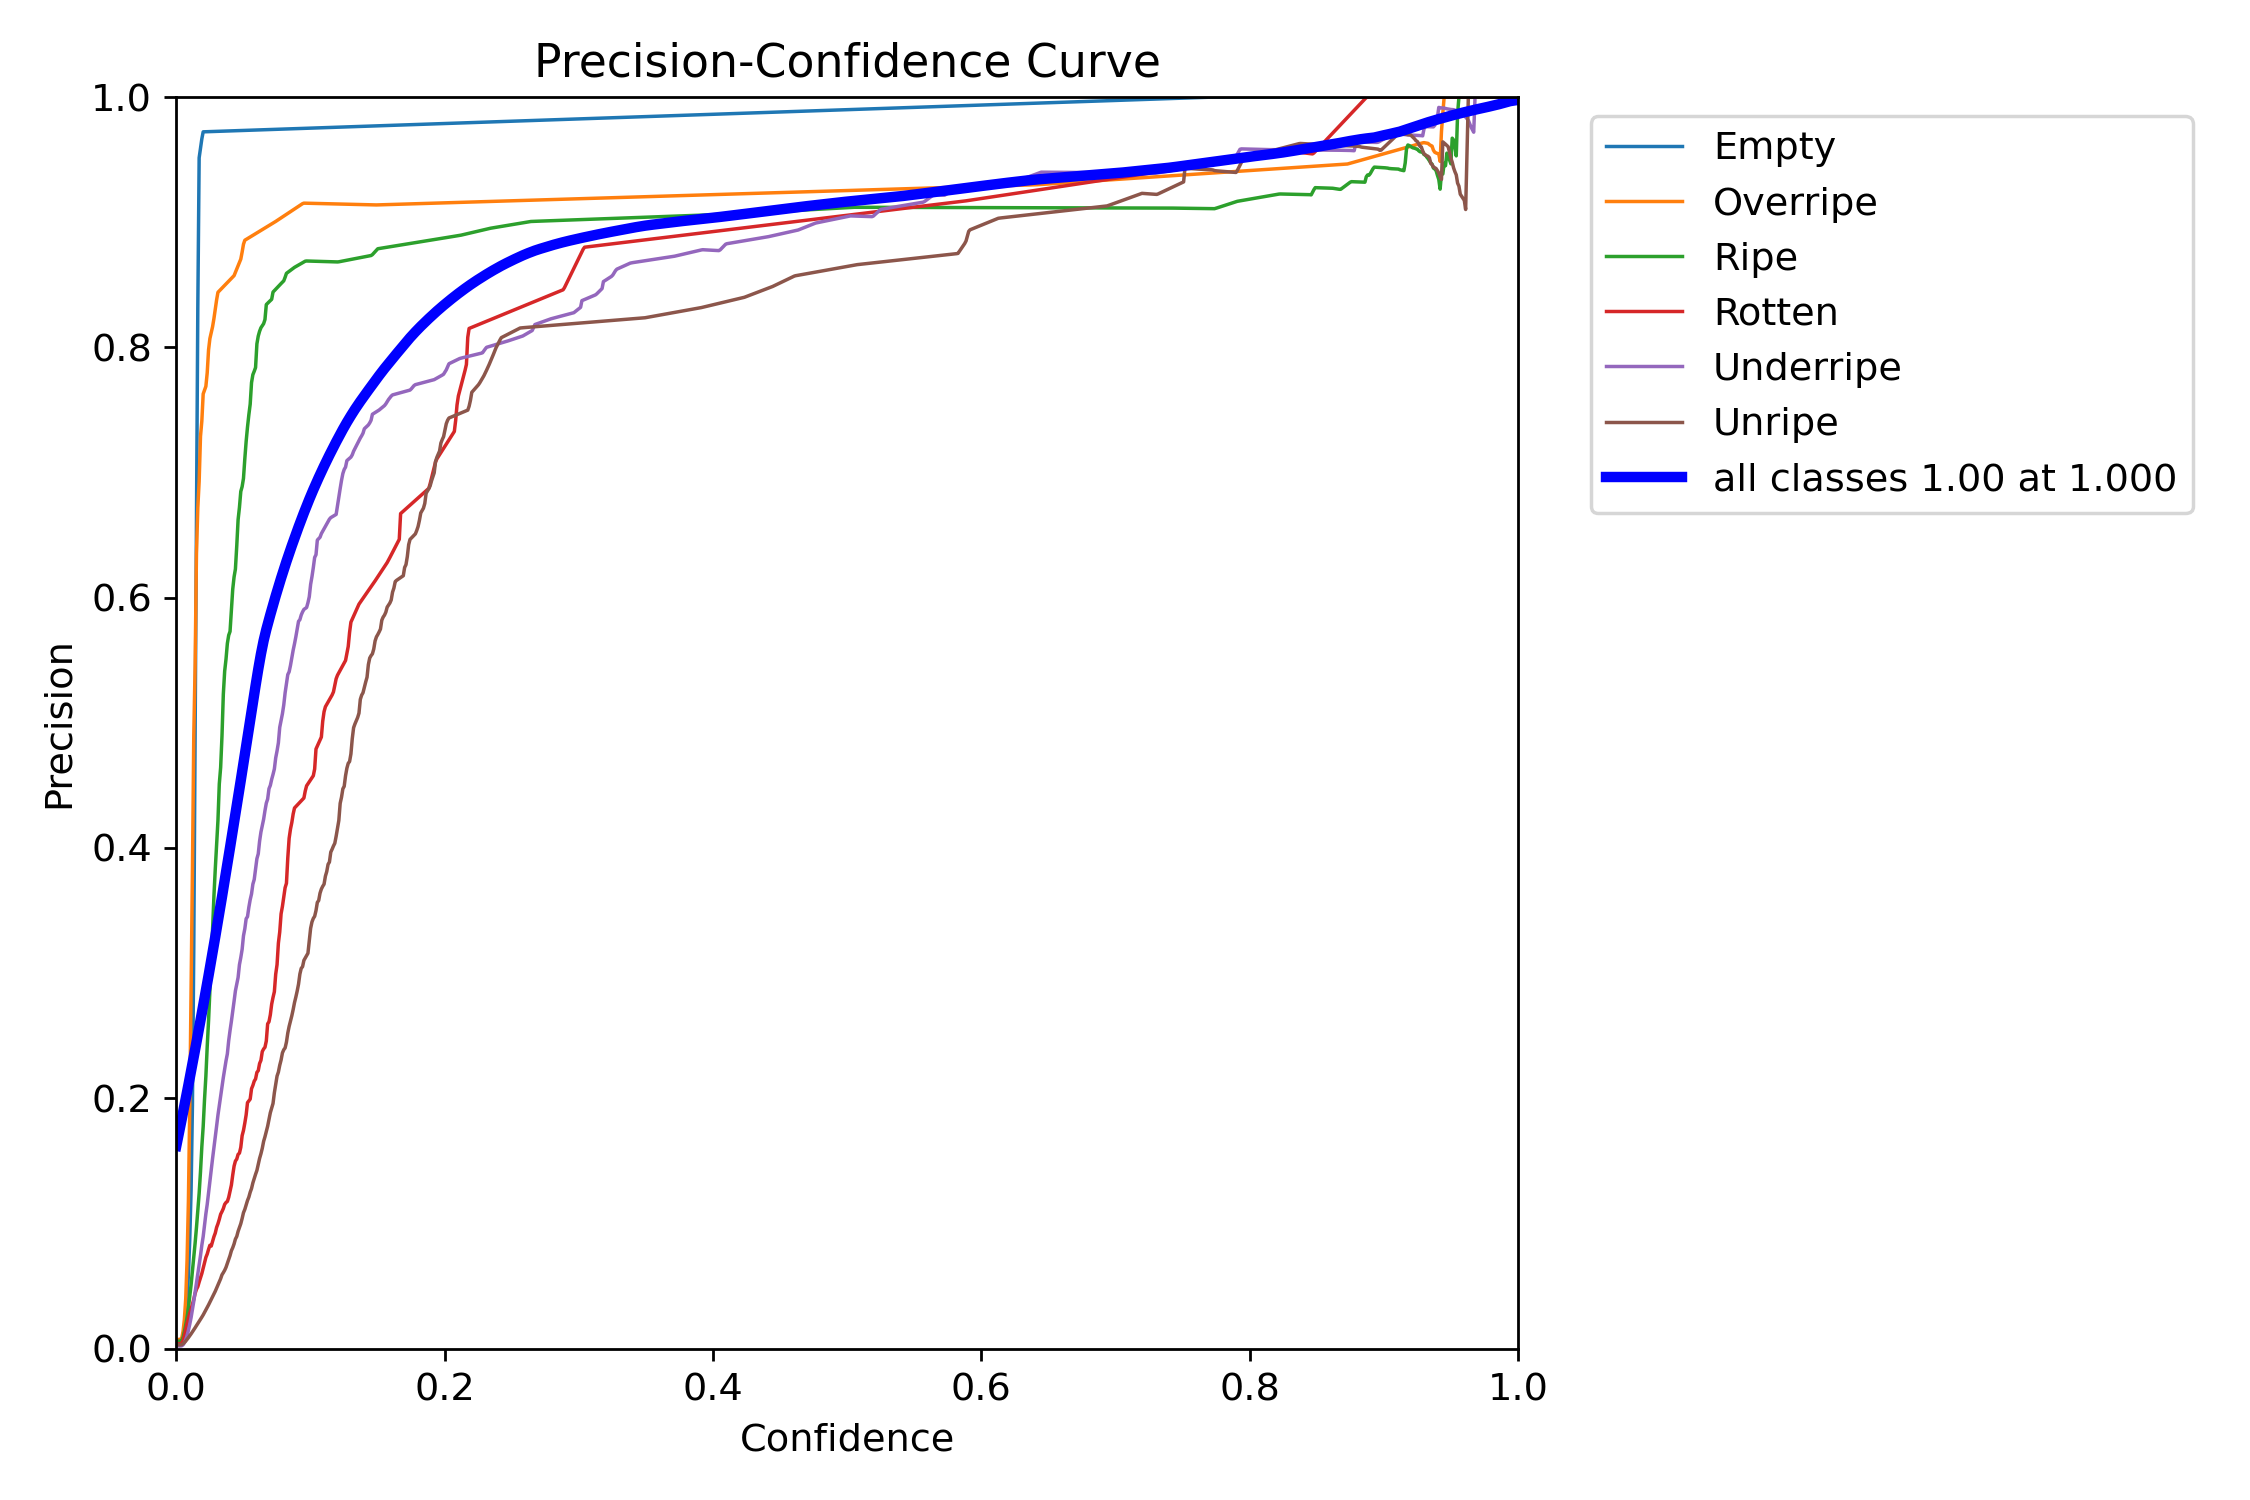

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/rtdetr_l_train2/BoxP_curve.png", width=1000)

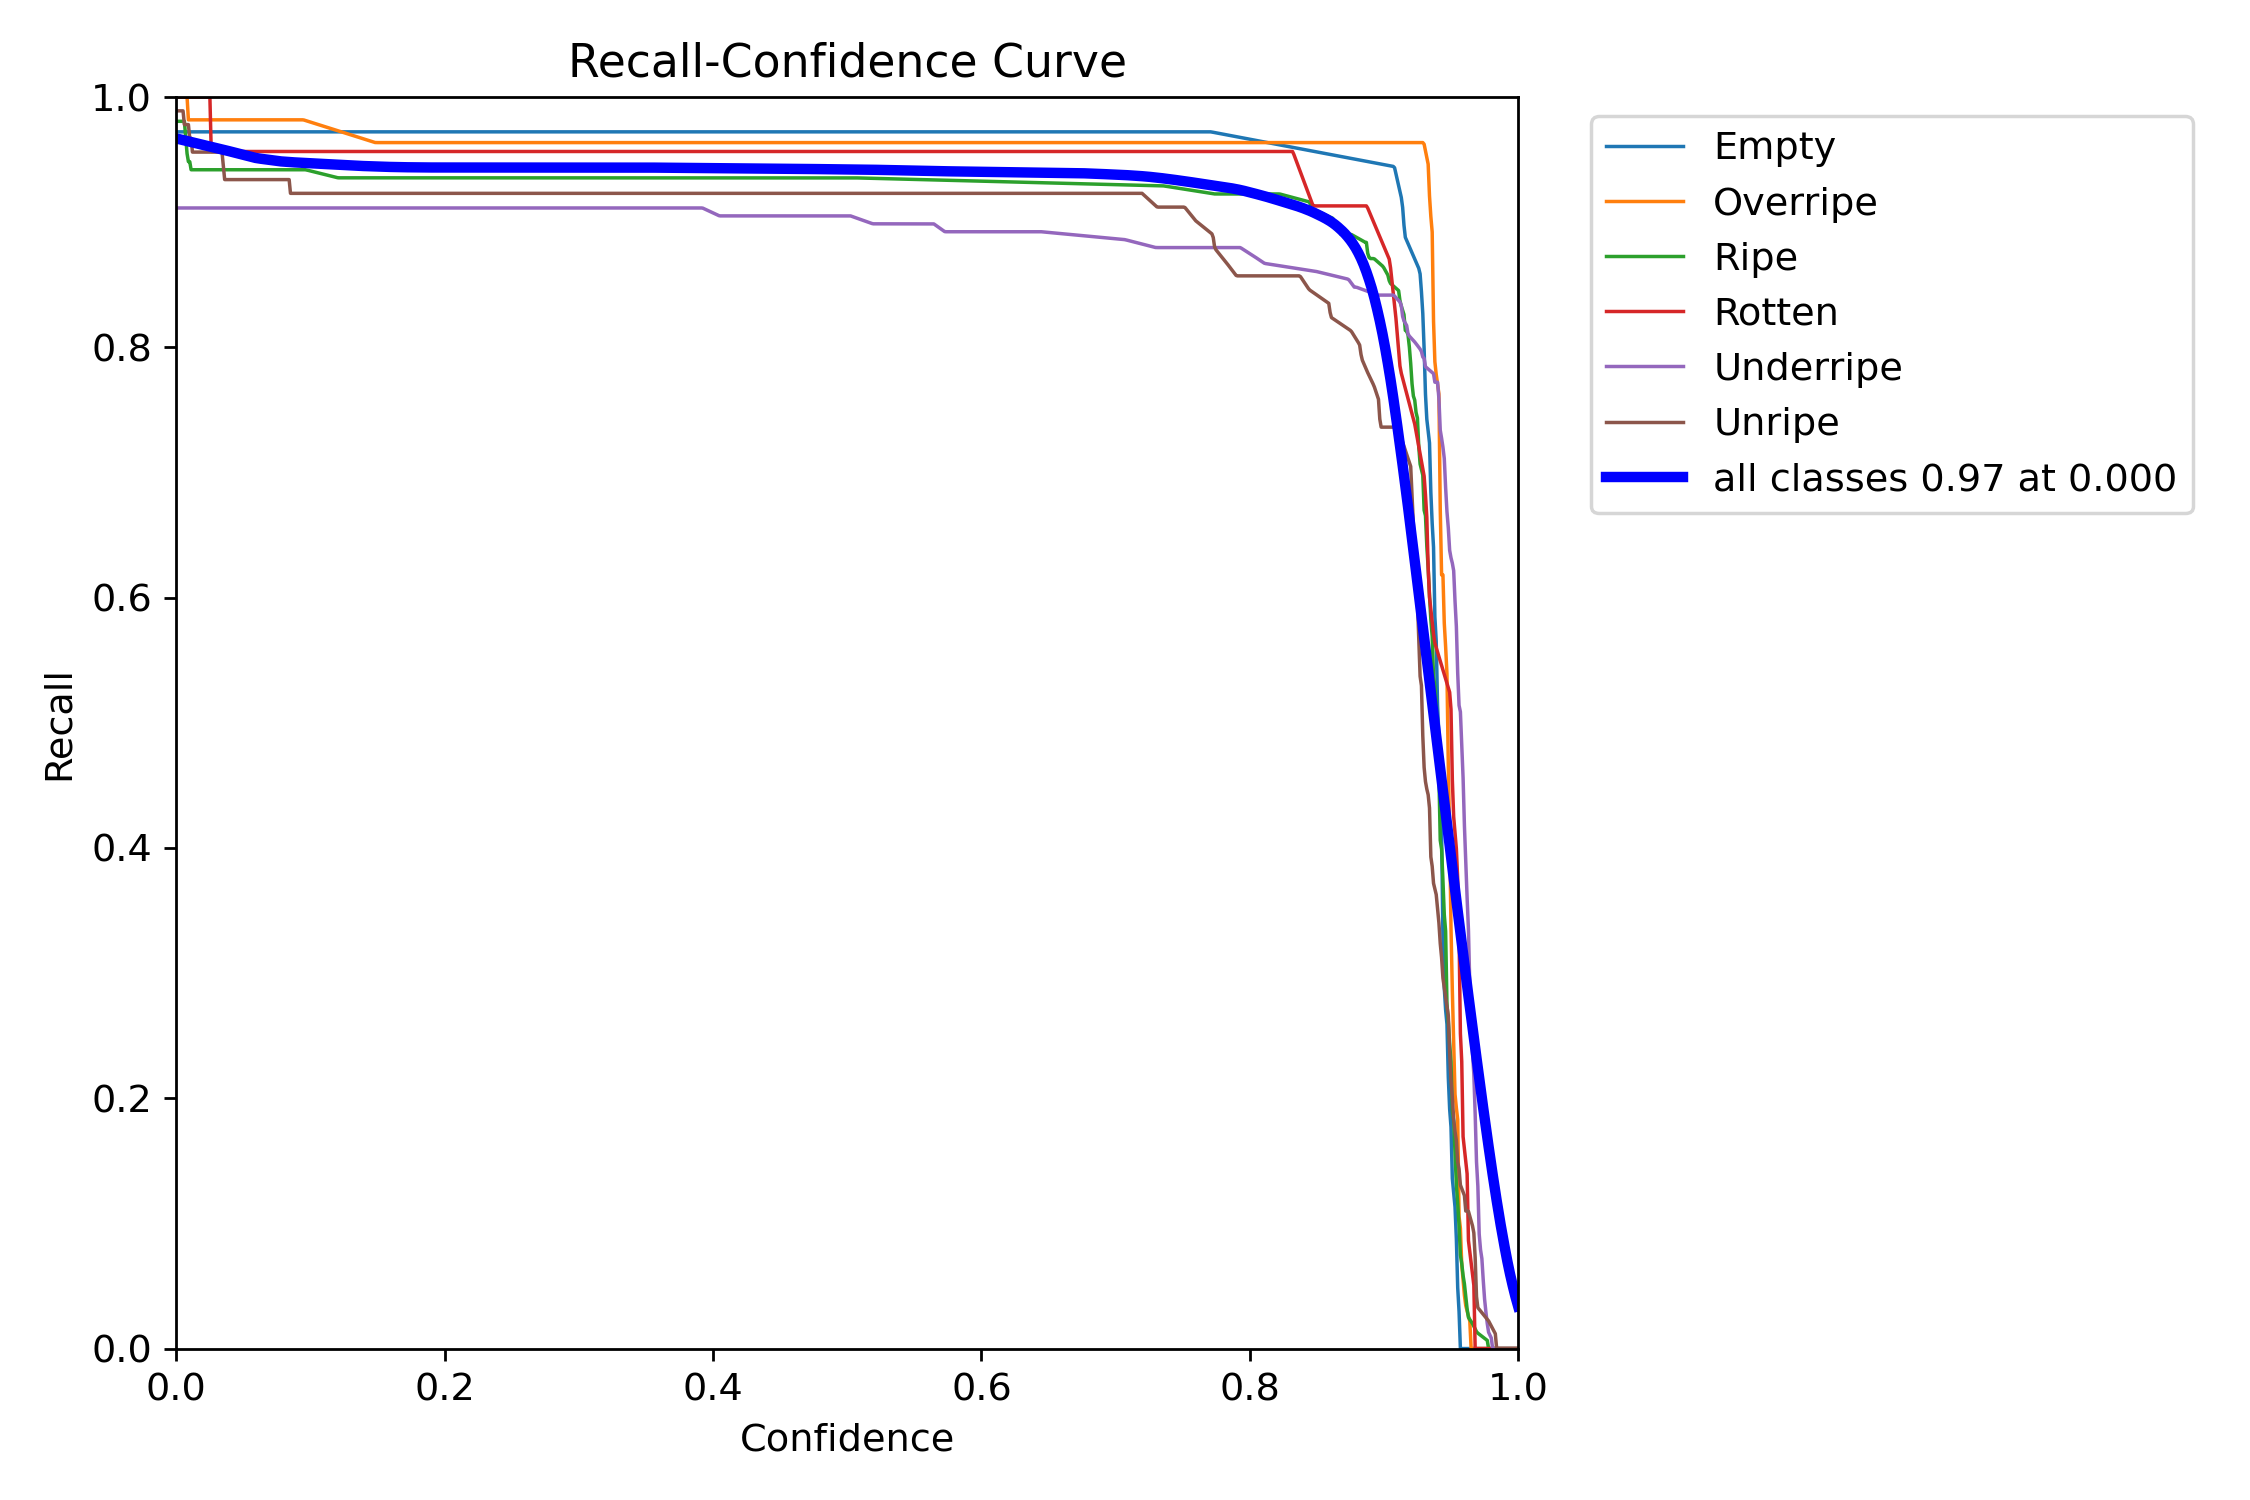

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/rtdetr_l_train2/BoxR_curve.png", width=1000)

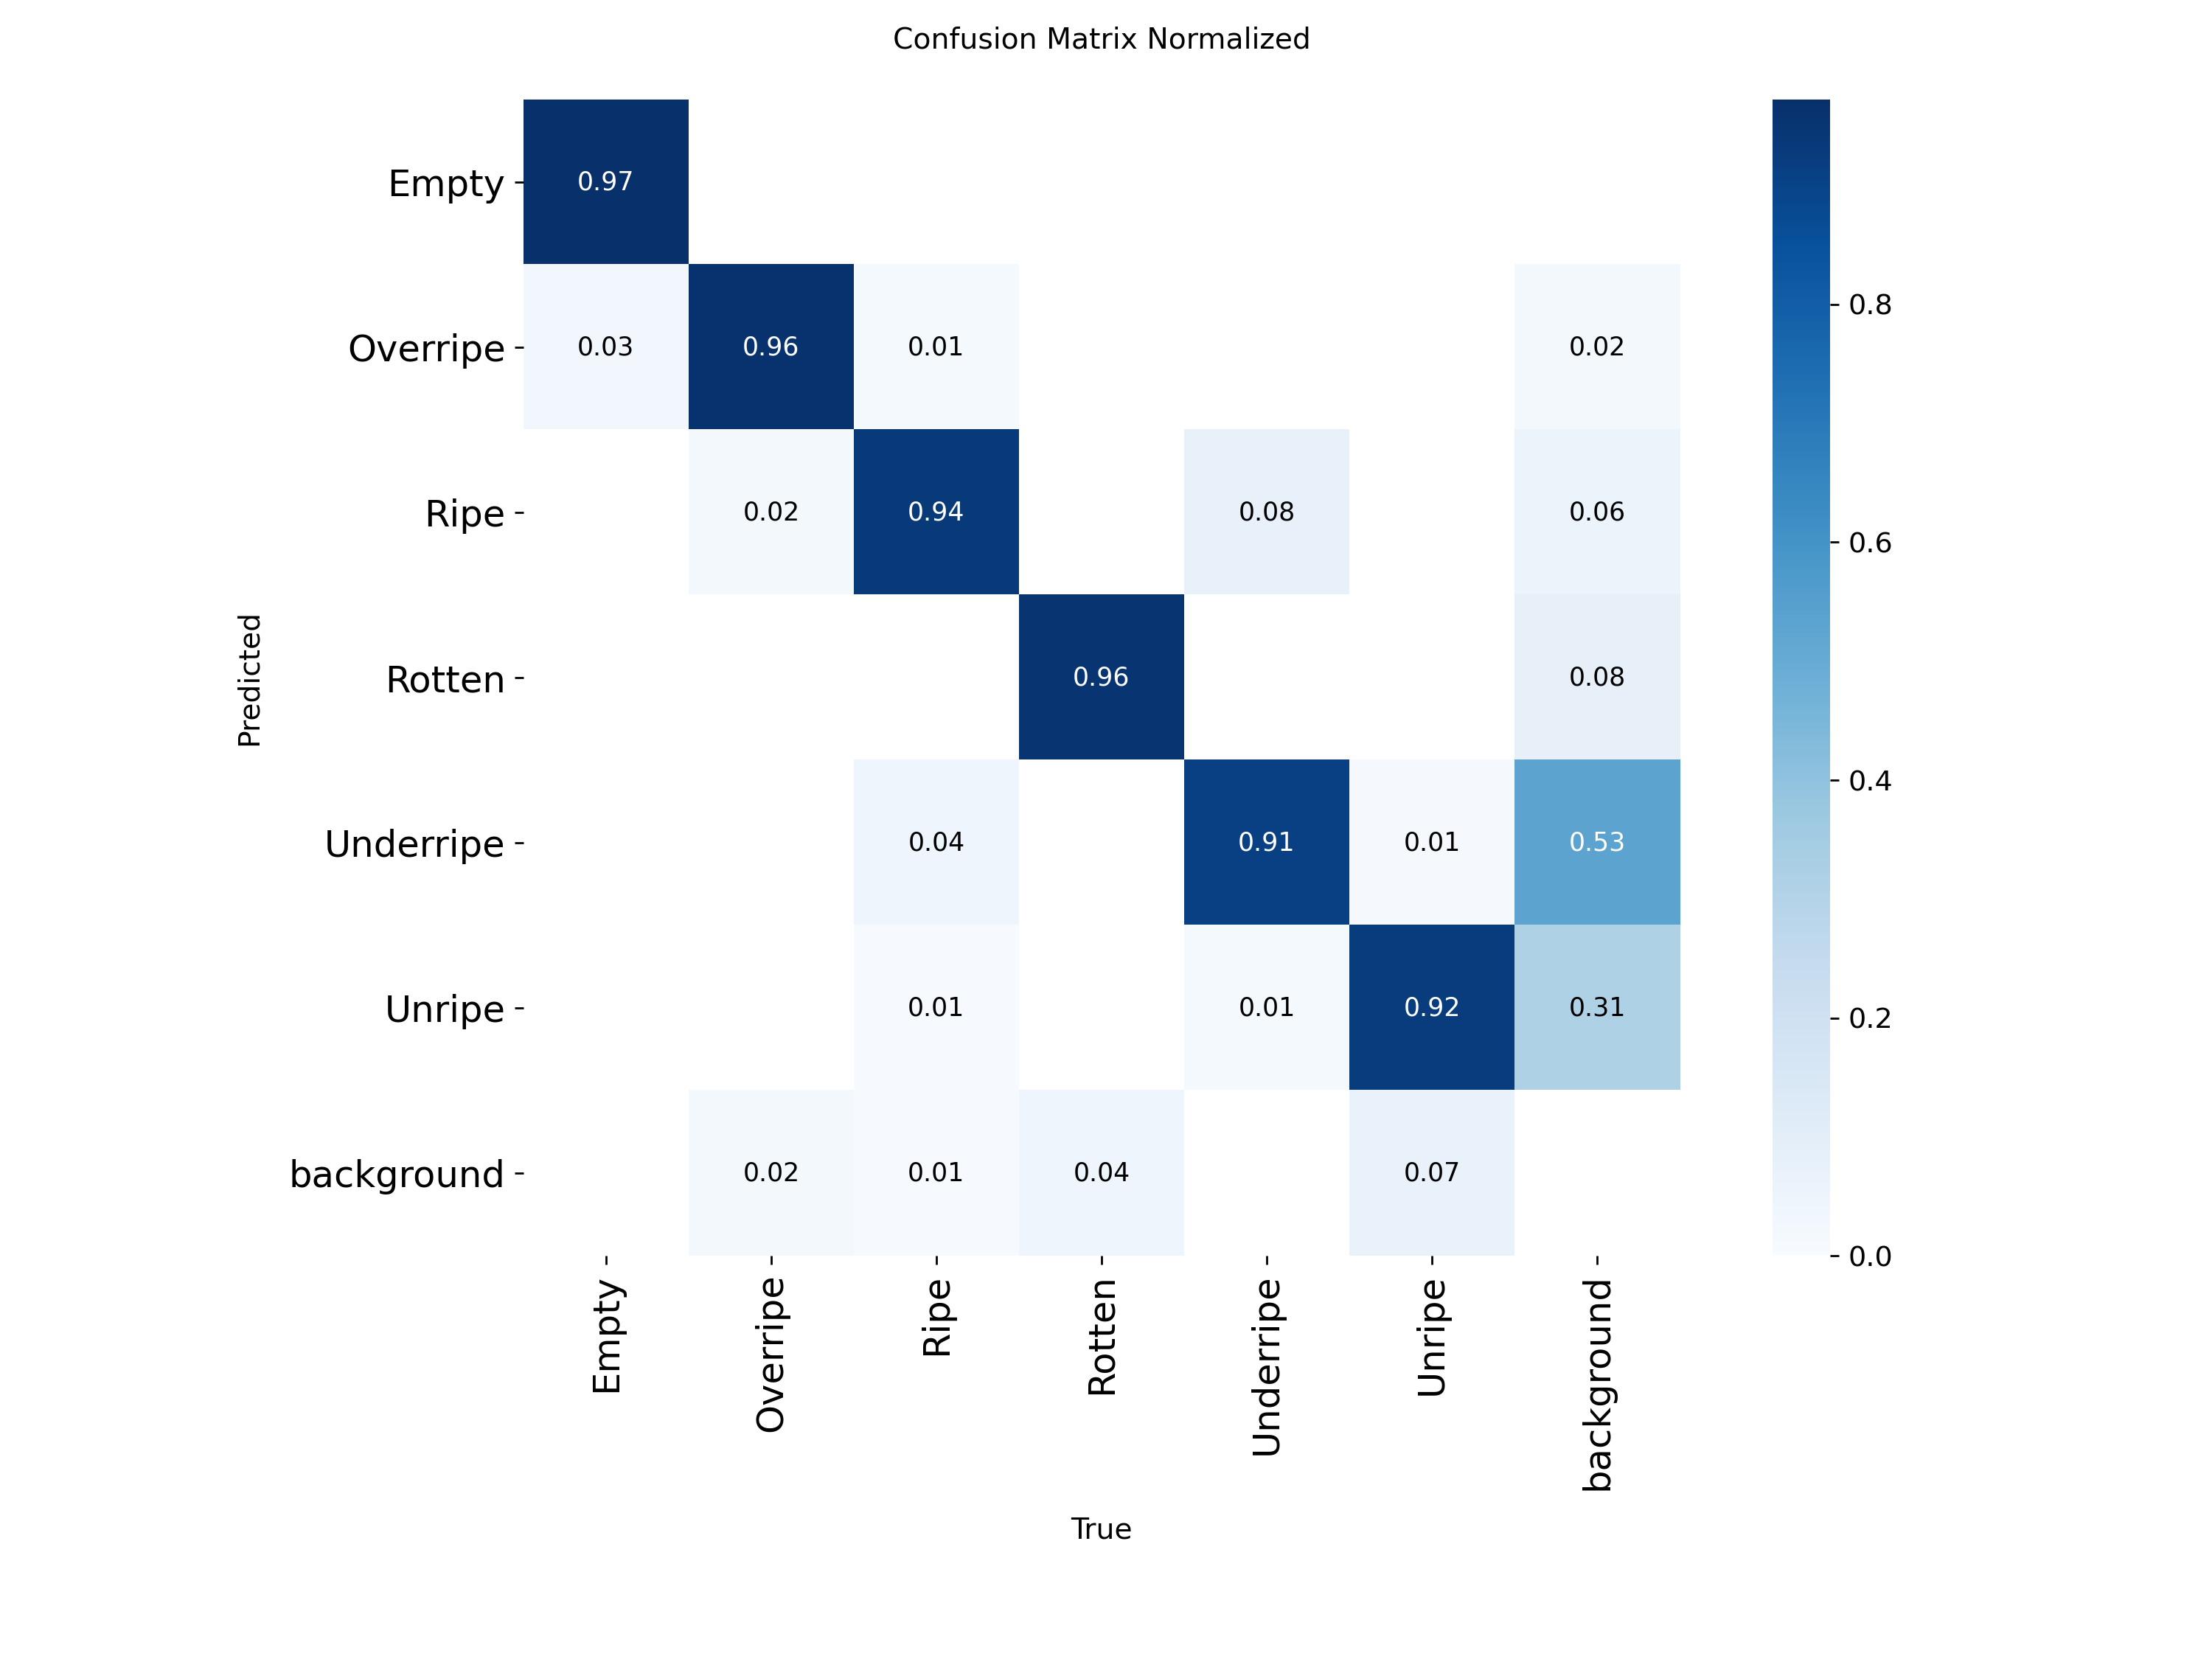

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/rtdetr_l_train2/confusion_matrix_normalized.png", width=1000)

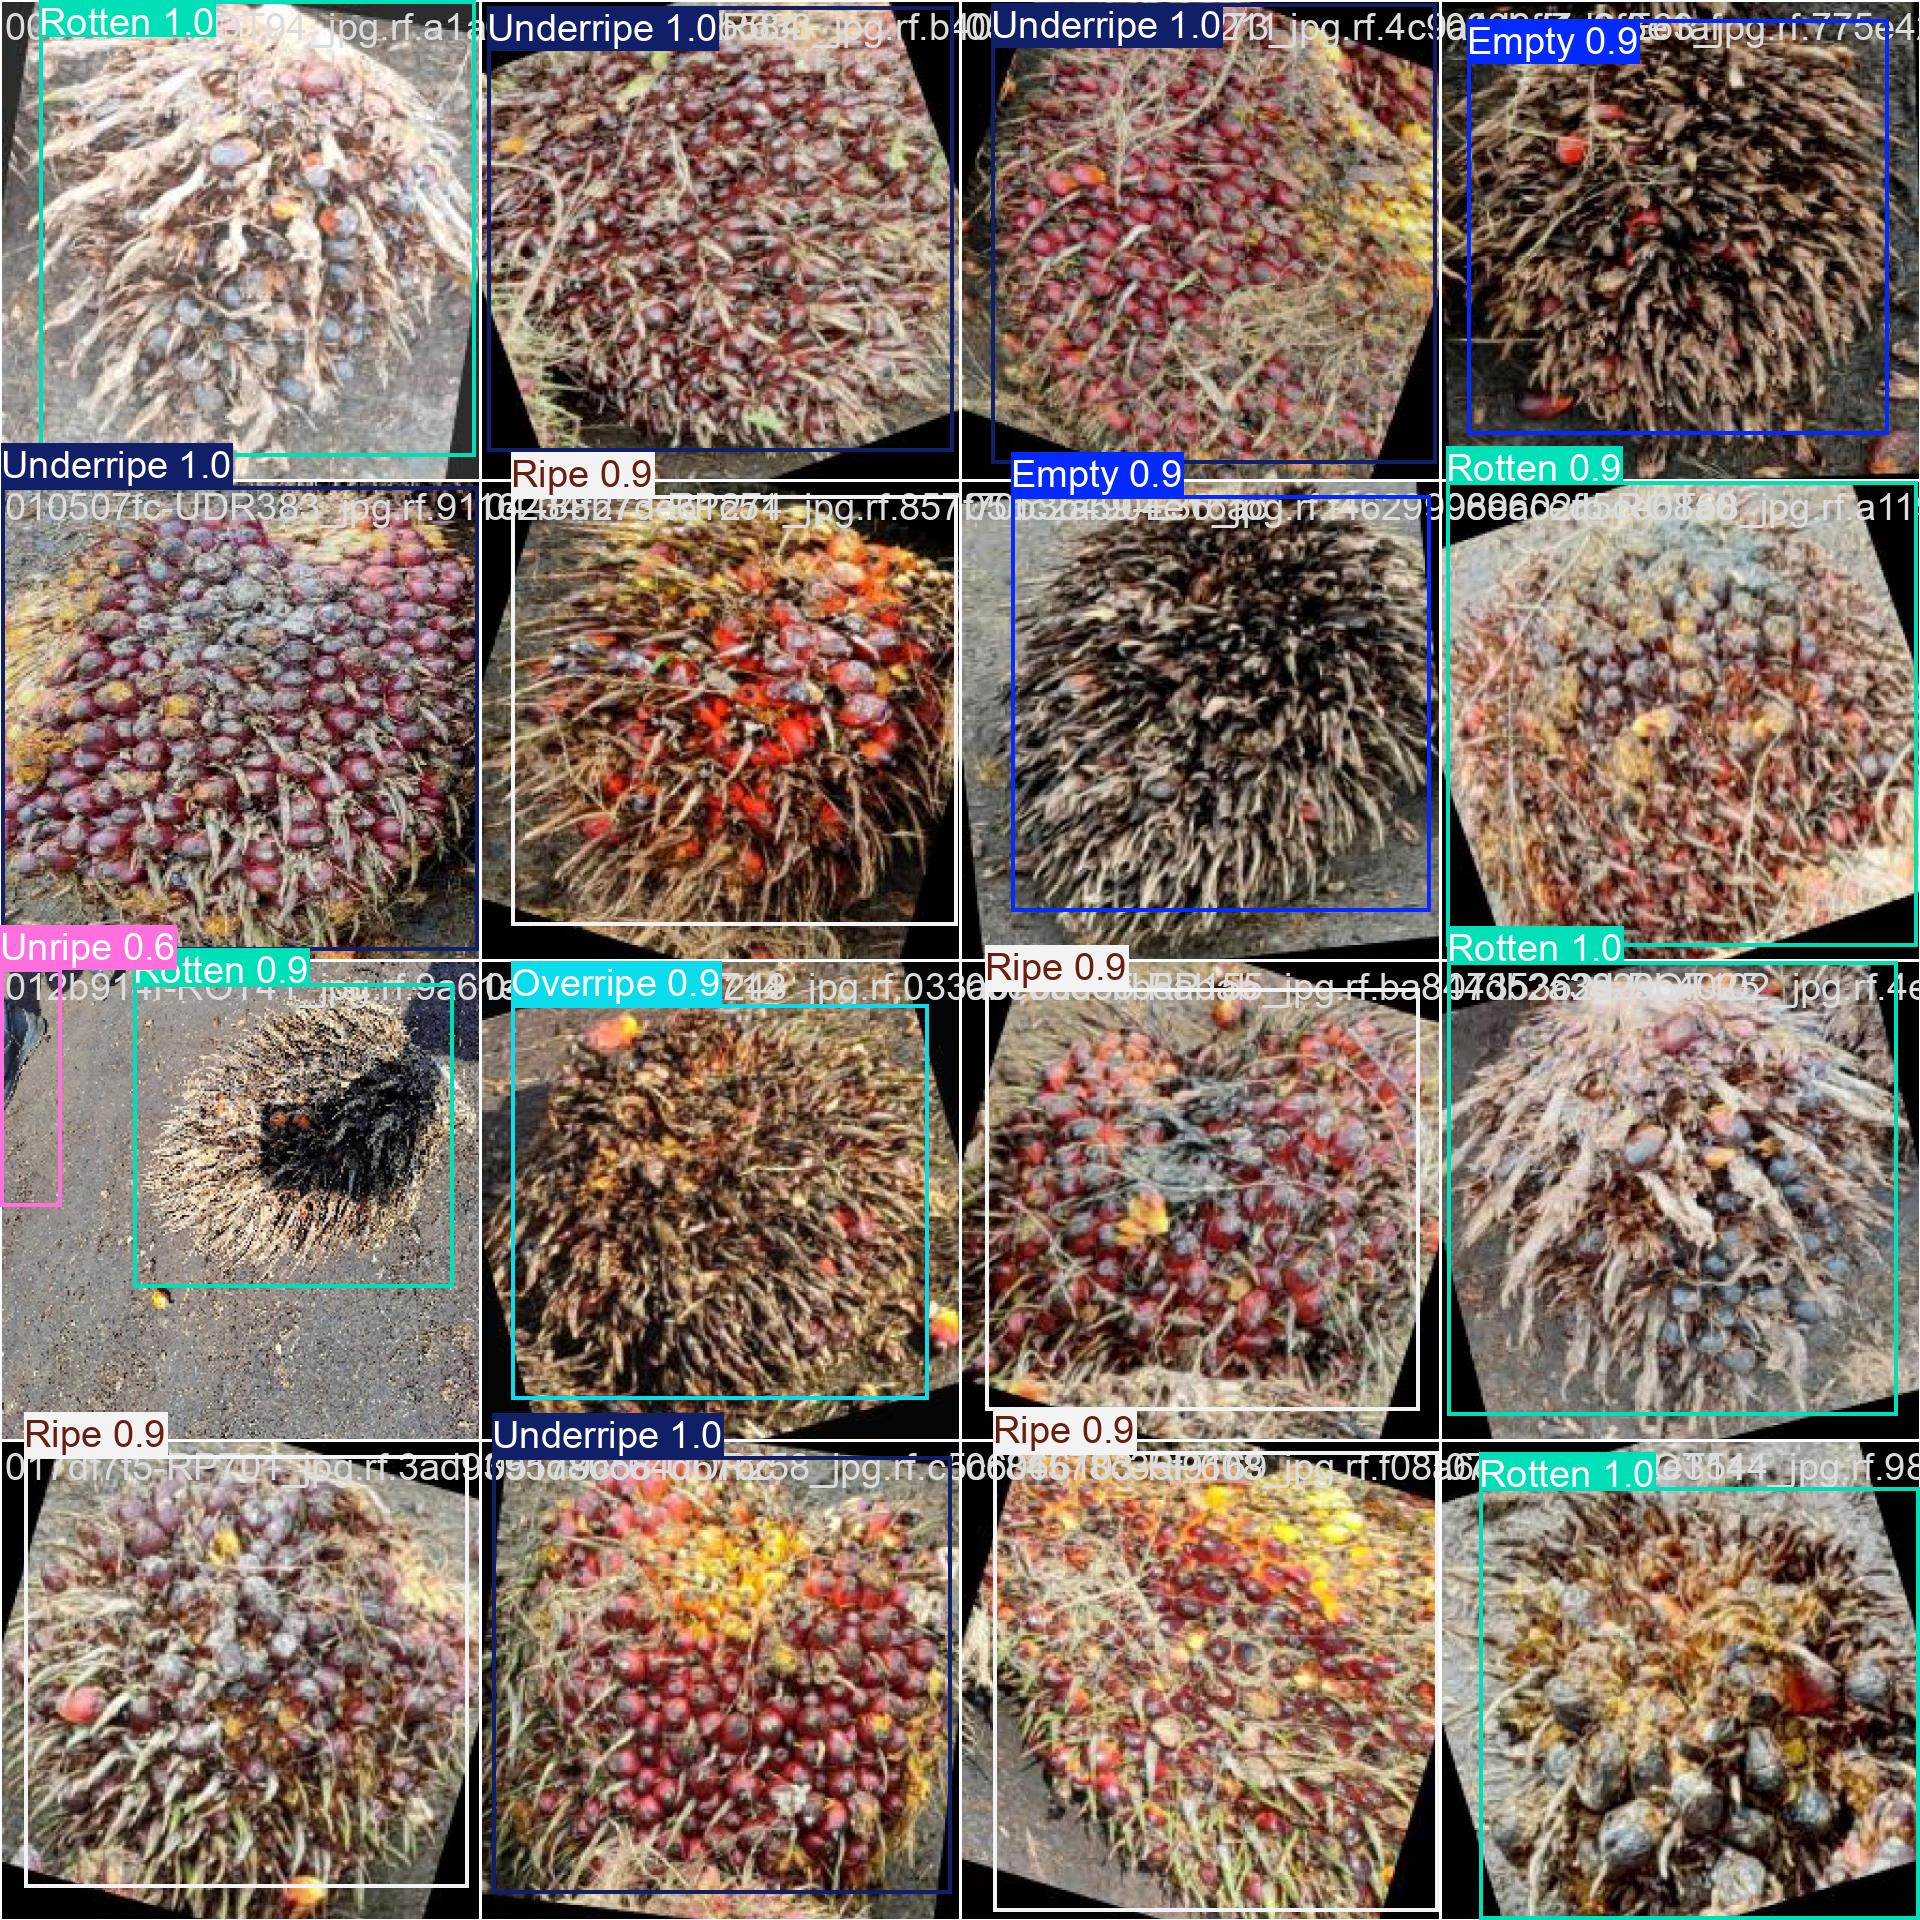

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/rtdetr_l_train2/val_batch0_pred.jpg", width=1000)

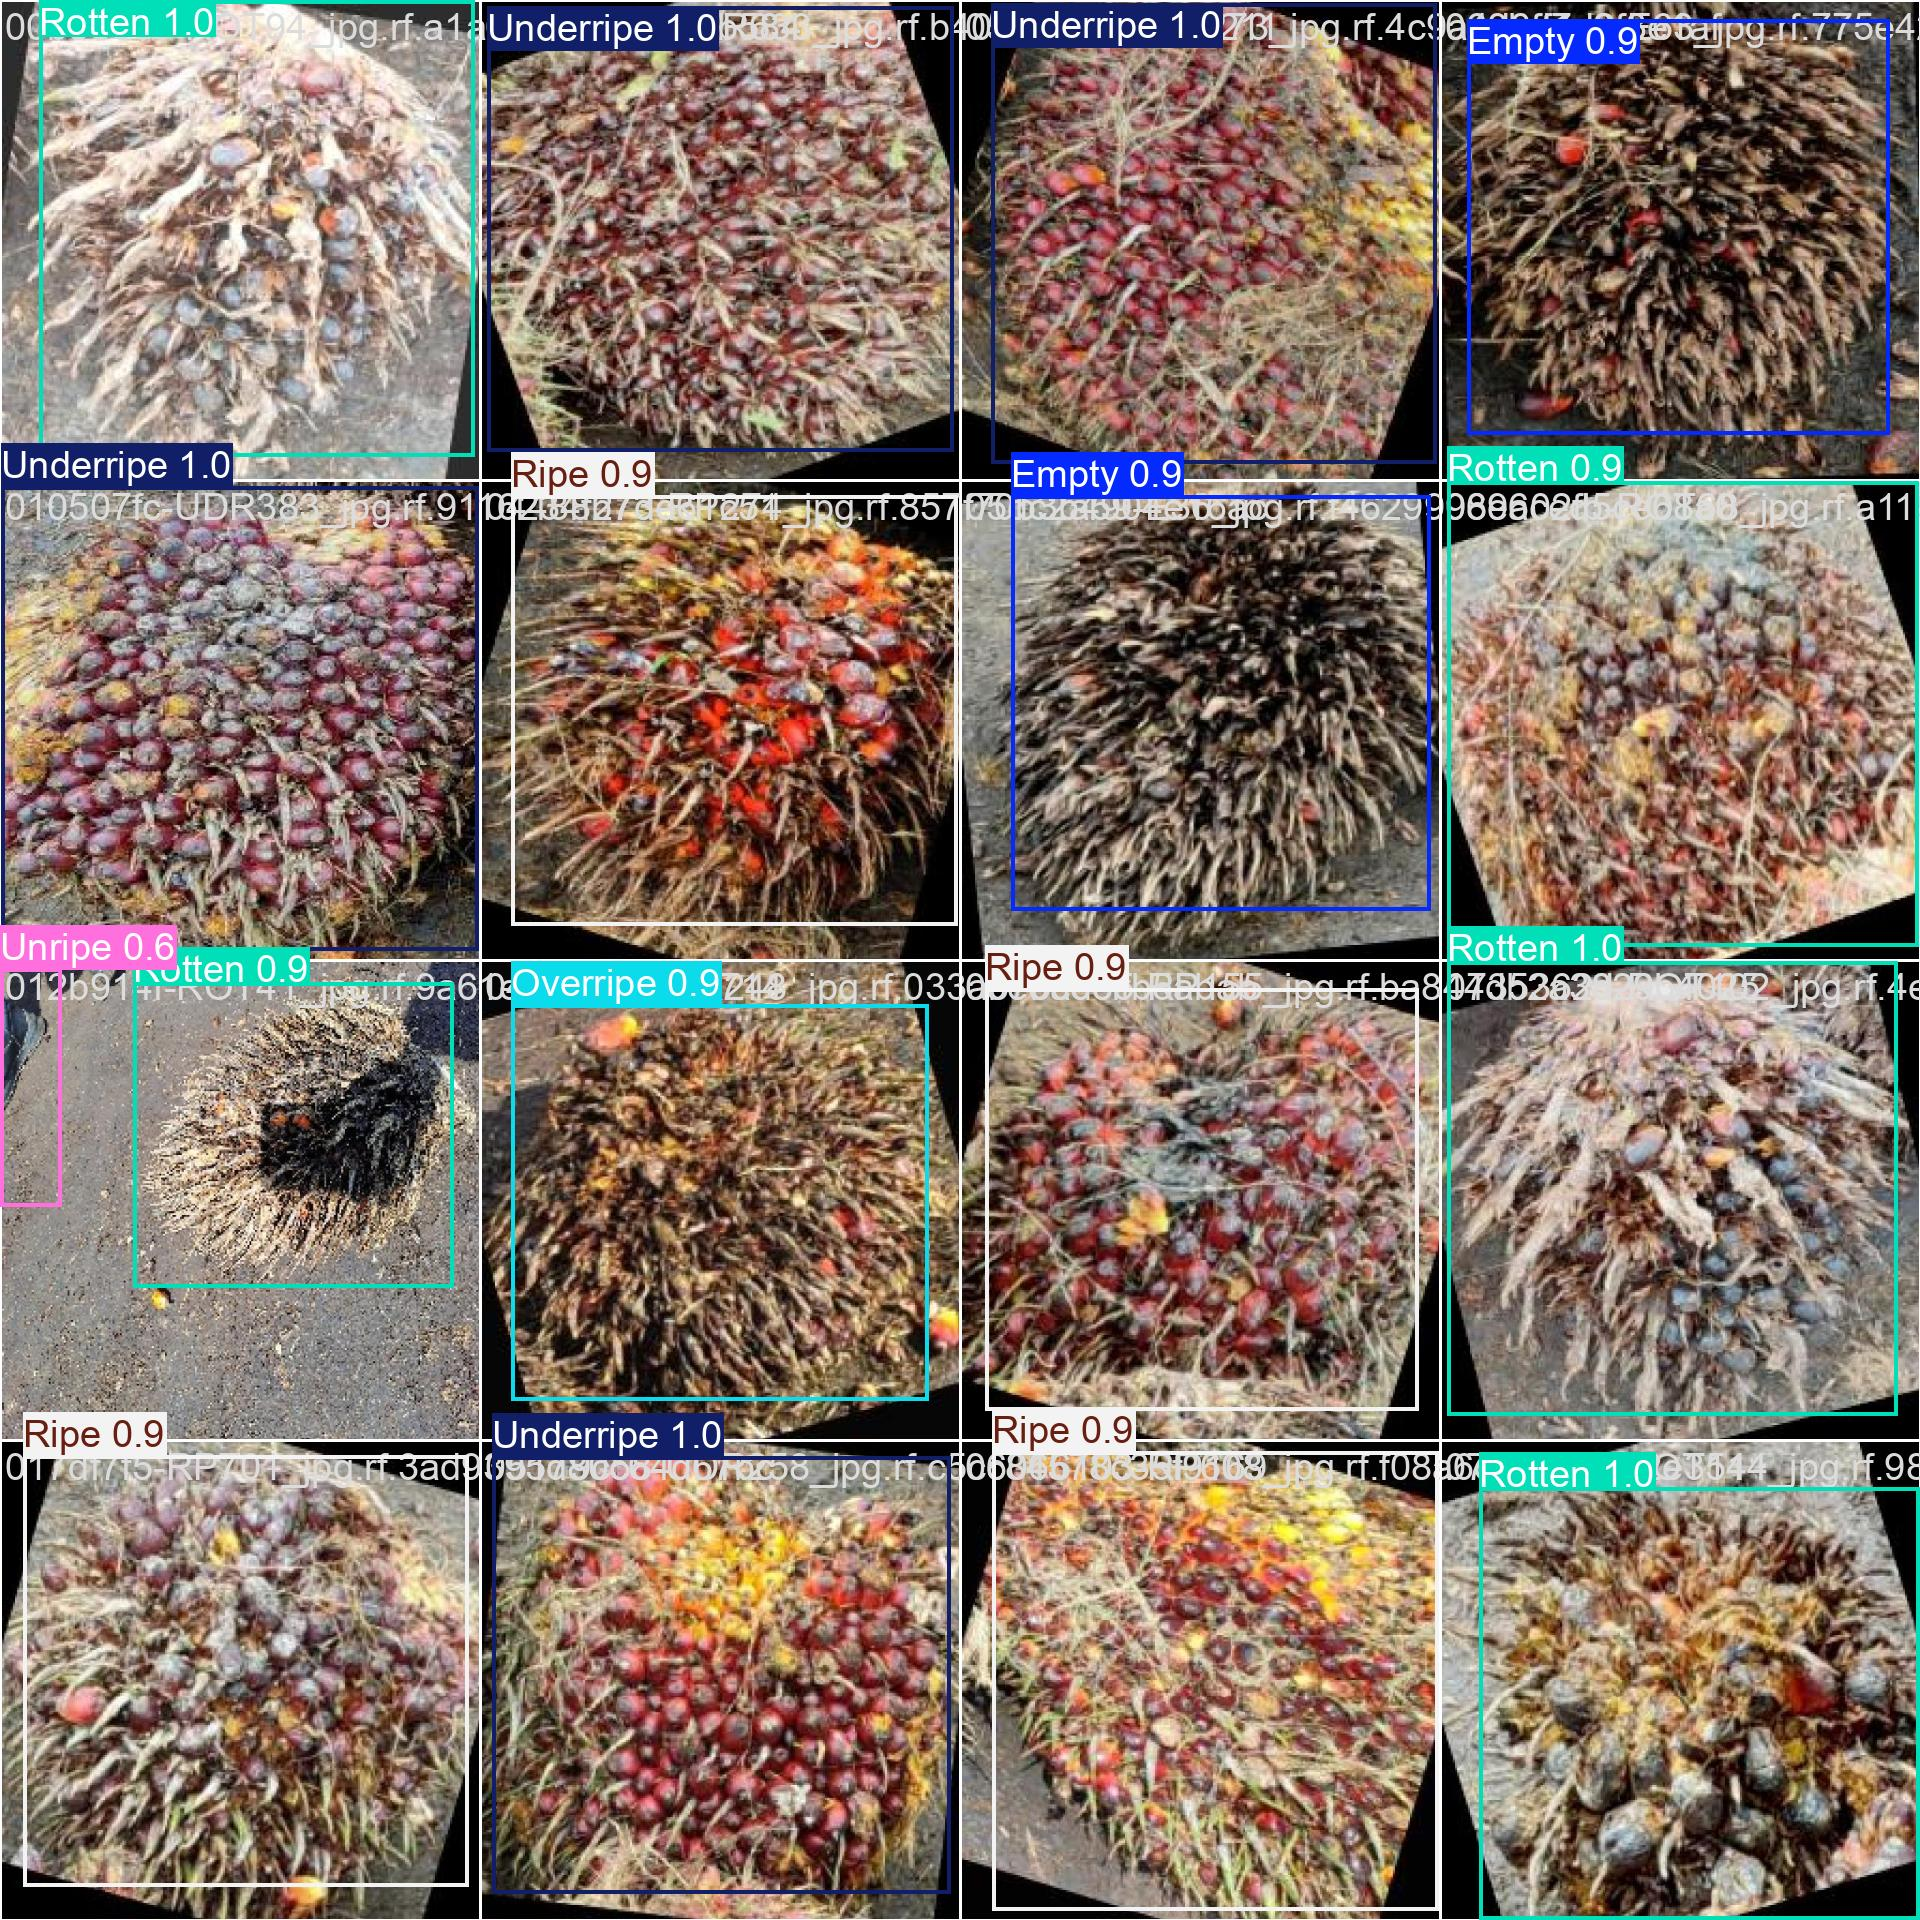

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/val/val_batch0_pred.jpg", width=1000)